In [40]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

time: 7.53 s (started: 2024-11-22 13:31:29 +00:00)


In [153]:
import ta
import yfinance as yf
import numpy as np
import pandas as pd
import joblib
from joblib import Parallel, delayed
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autotime

# Download historical price data for a stock
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK', 'GS']
print(len(tickers))
df = [yf.download(ticker, start="2010-11-01", end="2024-11-01") for ticker in tickers]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
26



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

time: 1.56 s (started: 2024-11-22 14:57:33 +00:00)


In [154]:
# aapl_close = df[0]["Close"].squeeze() 
# ma100 = aapl_close.rolling(100).mean()

# BB = ta.volatility.BollingerBands(aapl_close, window=20)
# high_band = BB.bollinger_hband()
# low_band = BB.bollinger_lband()
    
# plt.figure(figsize = (12,6))
# plt.plot(aapl_close)
# plt.plot(high_band, 'b')
# plt.plot(low_band, 'b')
# plt.plot(ma100, 'r')
# plt.grid(True)
# plt.title('Graph Of Moving Averages Of 100 Days and Bollinger Bands')

time: 611 µs (started: 2024-11-22 14:57:35 +00:00)


In [161]:
def process_stock(stock_data):
    """
    Process a single stock's data to calculate technical indicators
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock data with High, Low, Close columns
        
    Returns:
        tuple: (processed DataFrame, processed values as float32 array)
    """
    # Extract price series
    adj_close_prices = stock_data["Adj Close"].squeeze()
    close_prices = stock_data["Close"].squeeze()
    high_prices = stock_data["High"].squeeze()
    low_prices = stock_data["Low"].squeeze()
    volumes = stock_data["Volume"].squeeze()
    
    # Create a copy to avoid modifying the original
    df_processed = stock_data.copy()
    
    # Calculate momentum indicators
    df_processed["RSI"] = ta.momentum.rsi(close_prices, window=14)
    df_processed["WR"] = ta.momentum.WilliamsRIndicator(high_prices, low_prices, close_prices).williams_r()
    df_processed['Price Momentum'] = close_prices.pct_change() #Series of positive or negative percentage changes can indicate upward or downward trends
    df_processed['Volume Momentum'] = volumes.pct_change()
    
    #Rolling standard deviation 20
    df_processed['SD20'] = close_prices.rolling(window=20).std()
    
    # Calculate moving averages
    df_processed["SMA7"] = close_prices.rolling(window=7).mean()
    df_processed["SMA14"] = close_prices.rolling(window=14).mean()
    df_processed["SMA21"] = close_prices.rolling(window=21).mean()
    
    # Calculate exponential moving averages
    df_processed['EMA7'] = ta.trend.ema_indicator(close_prices, window=7)
    df_processed['EMA12'] = ta.trend.ema_indicator(close_prices, window=12)
    # df_processed['EMA25'] = ta.trend.ema_indicator(close_prices, window=25)
    df_processed['EMA26'] = ta.trend.ema_indicator(close_prices, window=26)
    df_processed['EMA99'] = ta.trend.ema_indicator(close_prices, window=99)
    df_processed['EMA200'] = ta.trend.ema_indicator(close_prices, window=200)
    
    # Calculate trend indicators
    df_processed["MACD"] = ta.trend.MACD(close_prices, window_slow=26, window_fast=12, window_sign=9).macd()
    df_processed["CCI"] = ta.trend.CCIIndicator(close_prices, high_prices, low_prices).cci()
    
    # Calculate volatility indicators
    BB = ta.volatility.BollingerBands(close_prices, window=20)
    df_processed["Upper Band"] = BB.bollinger_hband()
    df_processed["Lower Band"] = BB.bollinger_lband()
    df_processed["Ulcer Index"] = ta.volatility.UlcerIndex(close_prices).ulcer_index()
    
    # Prediction data
    df_processed["Close Next Day"] = adj_close_prices.shift(-1)
    
    # Clean and prepare final data
    df_processed.dropna(inplace=True)
    
    # Convert to float32 array
    values = df_processed.values
    
    return df_processed, values

def process_all_stocks(df):
    # Process all stocks in parallel
    results = Parallel(n_jobs=-1)(delayed(process_stock)(stock) for stock in df)
    # Unzip the results into separate lists
    processed_dfs, values_list = zip(*results)
    return list(processed_dfs), list(values_list)

processed_dfs, values_list = process_all_stocks(df)

time: 550 ms (started: 2024-11-22 15:01:28 +00:00)


In [162]:
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,Price Momentum,Volume Momentum,...,EMA12,EMA26,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-16,11.462602,13.588571,13.691786,13.430714,13.625714,498750000,53.720202,-40.920847,-0.007642,0.082958,...,13.487710,13.357526,12.679403,12.254809,0.130184,-27.794379,14.574053,12.850948,6.368184,11.461395
2011-08-17,11.461395,13.587143,13.732857,13.500000,13.653929,442061200,53.696962,-41.006850,-0.000105,-0.113662,...,13.503007,13.374535,12.697558,12.268066,0.128472,-18.157215,14.562744,12.839185,6.416486,11.027873
2011-08-18,11.027873,13.073214,13.308929,12.906071,13.244286,851435200,45.984883,-71.966454,-0.037825,0.926057,...,13.436885,13.352215,12.705071,12.276078,0.084670,-103.472151,14.564313,12.761759,6.686873,10.726006
2011-08-19,10.726006,12.715357,13.107143,12.714286,12.934643,775888400,41.513874,-93.293223,-0.027373,-0.088729,...,13.325881,13.305040,12.705276,12.280449,0.020841,-131.242553,14.568492,12.624472,7.120951,10.738355
2011-08-22,10.738355,12.730000,13.031429,12.681786,13.018214,535315200,41.763382,-91.561812,0.001152,-0.310062,...,13.234207,13.262445,12.705771,12.284922,-0.028238,-120.254959,14.517158,12.525591,7.472308,11.255330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,31109500,52.271541,-42.821761,-0.000823,-0.405024,...,231.616284,229.395186,218.972029,207.120253,2.221098,6.967201,237.468117,222.290882,2.031275,231.155685
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,0.003643,0.247281,...,231.584548,229.544431,219.220789,207.361942,2.040117,34.671127,237.613735,222.507266,1.664750,233.143494


time: 29.6 ms (started: 2024-11-22 15:01:28 +00:00)


In [163]:
def process_fourier_feature(stock_data):
    """
    Process a single stock's data to calculate technical indicators and Fourier components
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock data with High, Low, Close, Volume columns
        
    Returns:
        tuple: (processed DataFrame with Fourier features, processed values as float32 array)
    """
    # Extract price series
    close_prices = stock_data["Close"].squeeze()
    high_prices = stock_data["High"].squeeze()
    low_prices = stock_data["Low"].squeeze()
    volumes = stock_data["Volume"].squeeze()
    
    # Create a copy to avoid modifying the original
    df_processed = stock_data.copy()
    
    # Calculate Fourier transform of close prices
    close_fft = np.fft.fft(np.asarray(close_prices.tolist()))
    
    # Calculate basic Fourier statistics
    df_processed['Fourier Power'] = np.abs(close_fft)
    df_processed['Fourier Phase'] = np.angle(close_fft)
    
    # Create Fourier components features
    components_to_keep = [3, 6, 9, 100]
    for num_comp in components_to_keep:
        # Create copy of FFT list and zero out other frequencies
        fft_filtered = np.copy(close_fft)
        fft_filtered[num_comp:-num_comp] = 0
        
        # Inverse FFT to get the filtered signal
        ifft_signal = np.fft.ifft(fft_filtered)
        
        # Add real parts as features
        df_processed[f'Fourier {num_comp} Real'] = np.real(ifft_signal)
    
    # Add magnitude-threshold based features
    magnitude_threshold = 0.1 * np.max(np.abs(close_fft))
    significant_fft = np.copy(close_fft)
    significant_fft[np.abs(significant_fft) < magnitude_threshold] = 0
    ifft_significant = np.fft.ifft(significant_fft)
    
    # Add significant components features
    df_processed['Fourier Significant real'] = np.real(ifft_significant)
    
    # Drop any NaN values that might have been created
    df_processed.drop(df_processed.columns[0:6], axis=1, inplace=True)
    df_processed.dropna(inplace=True)
    
    # Convert to float32 array
    values = df_processed.values
    
    return df_processed, values

def process_all_stocks_2(df):
    # Process all stocks in parallel
    results = Parallel(n_jobs=-1)(delayed(process_fourier_feature)(stock) for stock in df)
    # Unzip the results into separate lists
    processed_dfs, values_list = zip(*results)
    return list(processed_dfs), list(values_list)

# Process all stocks in parallel
fourier_results = Parallel(n_jobs=-1)(delayed(process_fourier_feature)(stock) for stock in df)
fourier_dfs, fourier_values_list = process_all_stocks_2(df)

time: 396 ms (started: 2024-11-22 15:01:37 +00:00)


In [164]:
fourier_dfs[0]

Price,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real
Ticker,,,,,,,
Date,,,,,,,
2010-11-01,251631.774299,-1.538938e-17,103.455338,111.358324,112.276514,116.801757,110.981131
2010-11-02,124820.678654,1.066690e+00,103.178303,110.732082,111.322849,104.115764,110.421139
2010-11-03,63404.740343,1.633357e+00,102.901189,110.105361,110.368572,91.588075,109.860705
2010-11-04,25255.645241,1.559314e+00,102.623999,109.478189,109.413769,79.356255,109.299848
2010-11-05,26178.111649,1.048381e+00,102.346735,108.850595,108.458526,67.552176,108.738590
...,...,...,...,...,...,...,...
2024-10-25,30163.314500,-1.569032e+00,104.839212,114.481354,117.032685,177.737174,113.773702
2024-10-28,26178.111649,-1.048381e+00,104.562621,113.857934,116.083356,166.331105,113.216242


time: 11.2 ms (started: 2024-11-22 15:01:37 +00:00)


In [165]:
def plot_fourier_components(stock_data, figsize=(15, 10)):
    """
    Plot real parts of Fourier components and significant components
    
    Args:
        stock_data (pd.DataFrame): DataFrame containing stock price data with Close column
        figsize (tuple): Figure size for the plot
    """
    # Get close prices
    close_prices = stock_data["Close"].squeeze()
    
    # Calculate FFT
    close_fft = np.fft.fft(np.asarray(close_prices.tolist()))
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot Fourier components
    components = [3, 6, 9, 100]
    colors = ['blue', 'orange', 'green', 'red']
    
    for num_, color in zip(components, colors):
        # Filter FFT
        fft_filtered = np.copy(close_fft)
        fft_filtered[num_:-num_] = 0
        
        # Inverse FFT and get real part
        ifft_signal = np.fft.ifft(fft_filtered)
        
        plt.plot(ifft_signal, 
                label=f'Fourier {num_} components', 
                alpha=0.7,
                color=color)
    
    # Add significant components
    magnitude_threshold = 0.1 * np.max(np.abs(close_fft))
    significant_fft = np.copy(close_fft)
    significant_fft[np.abs(significant_fft) < magnitude_threshold] = 0
    ifft_significant = np.fft.ifft(significant_fft)
    
    plt.plot(ifft_significant, 
            label='Significant components', 
            alpha=0.7,
            color='orange',
            linestyle='--')
    
    # Plot original data
    plt.plot(close_prices.values, label='Original', color='purple')
    
    plt.title('Fourier Components Decomposition')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# plot_fourier_components(processed_dfs[5][2000:3000])
# plt.show()

time: 1.98 ms (started: 2024-11-22 15:01:38 +00:00)


In [166]:
def combine_dataframes_and_values(processed_dfs, fourier_dfs):
    """
    Combines two lists of dataframes using proper index alignment
    
    Args:
        processed_dfs: List of dataframes with date index
        fourier_dfs: List of dataframes with date index
    """
    combined_dfs = []
    combined_values = []
    
    for df1, df2 in zip(processed_dfs, fourier_dfs):
        # Make sure both dataframes have datetime index
        df1.index = pd.to_datetime(df1.index)
        df2.index = pd.to_datetime(df2.index)
        
        # Store the last column of df1
        last_col = df1.columns[-1]
        last_col_values = df1[last_col].copy()
        
        # Remove the last column from df1
        df1_without_last = df1.drop(columns=[last_col])
        
        # Merge on index (dates)
        df_combined = df1_without_last.join(df2, how='outer')
        
        # Add the last column back
        df_combined[last_col] = last_col_values
        
        #sort by oldest date
        df_combined = df_combined.sort_index(ascending=True)
        df_combined.dropna(inplace=True)
        
        # Replace infinite values with NaN
        df_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Fill NaN values (e.g., with the column mean or a specific value)
        df_combined.fillna(df_combined.mean(), inplace=True)
        
        # Define thresholds
        max_threshold = 1e6
        min_threshold = -1e6

        # Clip values to the threshold
        df_combined = df_combined.clip(lower=min_threshold, upper=max_threshold)
        
        if not np.isfinite(df_combined.values).all():
            print("Warning: Data contains NaN or infinite values")
        
        combined_dfs.append(df_combined)
        combined_values.append(df_combined.values.astype('float64'))
    
    return combined_dfs, combined_values

combined_dfs, combined_values = combine_dataframes_and_values(processed_dfs, fourier_dfs)

time: 1.5 s (started: 2024-11-22 15:01:39 +00:00)


In [167]:
combined_values[0]

array([[ 11.46260166,  13.58857059,  13.69178581, ...,  12.35630463,
         16.00035709,  11.46139526],
       [ 11.46139526,  13.58714294,  13.73285675, ...,  12.75120806,
         15.71127618,  11.02787304],
       [ 11.02787304,  13.07321358,  13.30892944, ...,  13.1681861 ,
         15.42476428,  10.72600555],
       ...,
       [233.14349365, 233.3999939 , 234.72999573, ..., 166.33110497,
        113.21624209, 233.41319275],
       [233.41319275, 233.66999817, 234.33000183, ..., 154.40576181,
        112.65823403, 229.84712219],
       [229.84712219, 230.1000061 , 233.47000122, ..., 142.08624598,
        112.0996988 , 225.66172791]])

time: 2.98 ms (started: 2024-11-22 15:01:40 +00:00)


In [168]:
from statsmodels.tsa.arima.model import ARIMA

series = combined_dfs[0].iloc[:, 1]
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      ('Close', 'AAPL')   No. Observations:                 3324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6458.729
Date:                Fri, 22 Nov 2024   AIC                          12929.458
Time:                        15:01:40   BIC                          12966.110
Sample:                             0   HQIC                         12942.573
                               - 3324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0178      0.010     -1.857      0.063      -0.037       0.001
ar.L2         -0.0253      0.010     -2.445      0.015      -0.046      -0.005
ar.L3         -0.0256      0.011     -2.361      0.0

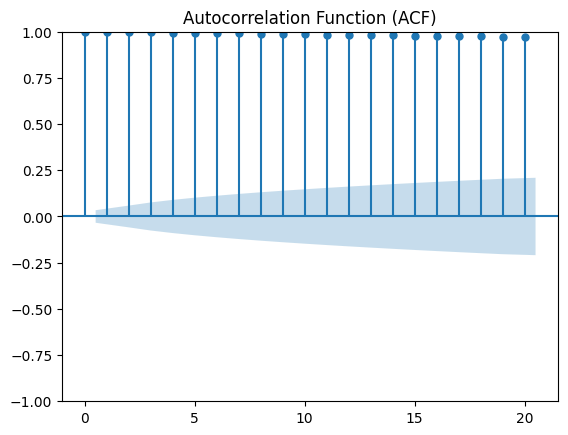

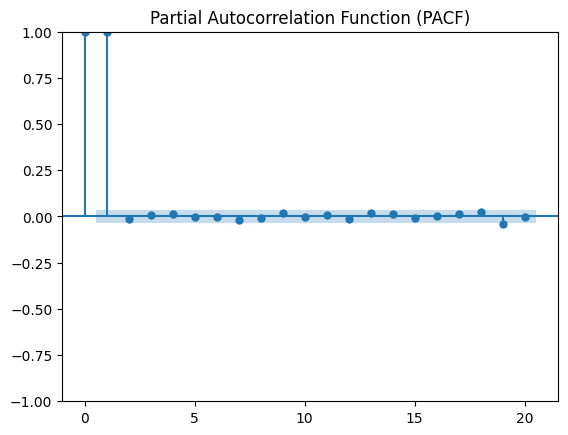

"\nBased on your ACF and PACF plots:\n\nFrom the ACF Plot:\n\nThe ACF shows high and persistent autocorrelations, indicating non-stationarity.\nThis suggests you need first-order differencing (d=1) to make the series stationary.\nFrom the PACF Plot:\n\nThe PACF cuts off sharply after lag 2, with only the first two lags being significant.\nThis suggests that the series has an AR (autoregressive) component with p=2.\n\np=2: From the PACF plot.\nd=1: To account for non-stationarity observed in the ACF plot.\nq=0: Since the ACF does not show a distinct cutoff, there's no strong indication of a Moving Average (MA) component.\nThus, the best order to start with is ARIMA(2, 1, 0).\n"

time: 304 ms (started: 2024-11-22 15:01:41 +00:00)


In [169]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Plot ACF and PACF to identify p, d, q
plot_acf(series, lags=20)
plt.title("Autocorrelation Function (ACF)")
plt.show()

plot_pacf(series, lags=20)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

"""
Based on your ACF and PACF plots:

From the ACF Plot:

The ACF shows high and persistent autocorrelations, indicating non-stationarity.
This suggests you need first-order differencing (d=1) to make the series stationary.
From the PACF Plot:

The PACF cuts off sharply after lag 2, with only the first two lags being significant.
This suggests that the series has an AR (autoregressive) component with p=2.

p=2: From the PACF plot.
d=1: To account for non-stationarity observed in the ACF plot.
q=0: Since the ACF does not show a distinct cutoff, there's no strong indication of a Moving Average (MA) component.
Thus, the best order to start with is ARIMA(2, 1, 0).
"""

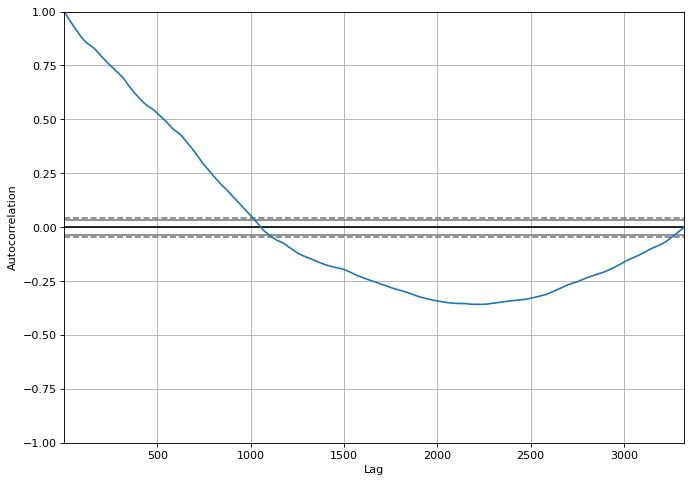

time: 168 ms (started: 2024-11-22 15:01:41 +00:00)


In [170]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 7), dpi=80)
autocorrelation_plot(series)
plt.show()

In [171]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

time: 2min 28s (started: 2024-11-22 15:01:42 +00:00)


Test MSE: 8.371


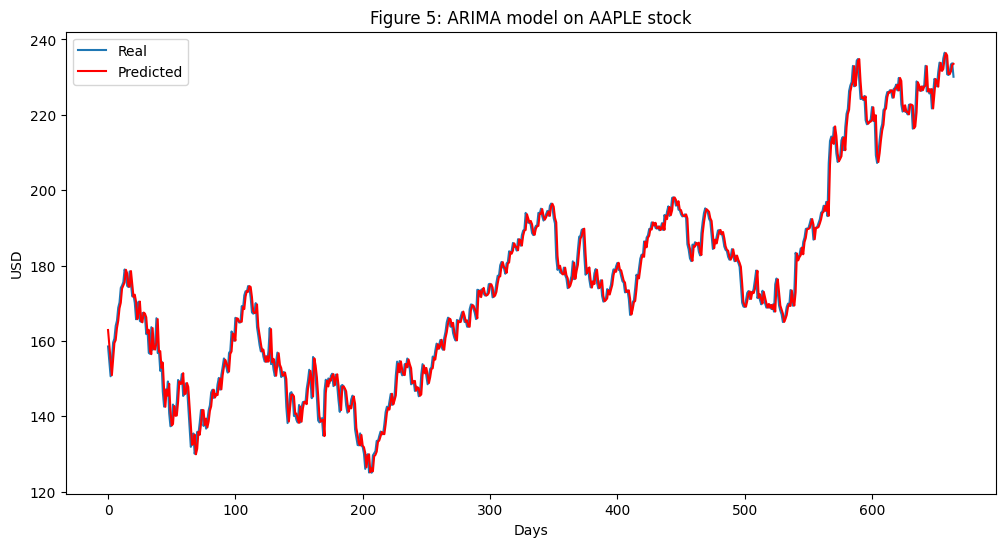

time: 204 ms (started: 2024-11-22 15:04:10 +00:00)


In [172]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on AAPLE stock')
plt.legend()
plt.show()

In [173]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close Next Day']
    X = data.iloc[:, :-1]
    
    train_samples = int(X.shape[0] * 0.8)
    
    train_X = X.iloc[:train_samples]
    test_X = X.iloc[train_samples:]

    train_y = y.iloc[:train_samples]
    test_y = y.iloc[train_samples:]
    
    return (train_X, train_y), (test_X, test_y)

(train_X, train_y), (test_X, test_y) = get_feature_importance_data(combined_dfs[0])

time: 3.01 ms (started: 2024-11-22 15:04:10 +00:00)


In [ ]:
import xgboost as xgb

regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(train_X, train_y,
                         eval_set = [(train_X, train_y), (test_X, test_y)],
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=test_X.columns)
plt.title('Feature importance of the technical indicators.')
plt.show()

In [ ]:
def save_processed_data(processed_dfs='', values_list='', output_dir='processed_data'):
    """
    Save processed DataFrames list and numpy arrays list to single files
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save list of DataFrames using pickle
    with open(output_path / 'processed_dfs.pkl', 'wb') as f:
        joblib.dump(processed_dfs, f)
    
    # Save numpy arrays
    with open(output_path / 'values_array.pkl', 'wb') as f:
        joblib.dump(values_list, f)

def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

# Save both lists
save_processed_data(combined_dfs, combined_values, 'processed_data')

# Later load them
# loaded_dfs, loaded_values = load_processed_data('processed_data')